<a href="https://colab.research.google.com/github/GetOffMyBiscuits/Pixel-Art-Generator/blob/main/PixelArtGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

QUICK START GUIDE

Ensure that the Runtime > Change Runtime Type is set to 'GPU'
otherwise it will be very inefficient when generating images

# **Pixel Art Generator v1.0**
by Joshua Hillary

In [ ]:
#@title Upload Dataset from Google Drive
# To import our pokemon images via your Google Drive they must be stored in your google drive as a zip,
# then here we mount our drive and it will appear in our instance files; uncomment the following lines to use 
# from google.colab import drive
# drive.mount('/content/drive')

# Otherwise you can just use my shared google drive link to download the Pokemon Dataset
!gdown '1r5Dr0gd_2p01XwxPZlmRJqjm4iY42li0&confirm=t' 
!unzip "/content/Pokemon.zip"

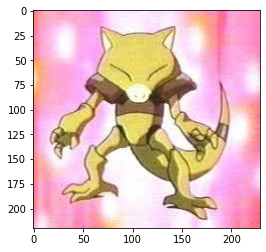

In [ ]:
#@title Imports and Data Directory
#imports
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from IPython.display import Image
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
# import pickle as pkl
import seaborn as sb
import torch
import os

# Set the filepath of our images and print an example image using matplotlib to ensure its working
data_dir = '/content/PokemonData' #@param {type:"string"}
dataset = ImageFolder(data_dir)
img, label = dataset[0]
plt.imshow(img)

In [ ]:
#@title Image Prep
#Here we set our target image size, the batch size, and stats to normalize the image
image_size = 64 
batch_size = 128 # @param {type: "slider", min:0, max:1024, step: 32}
norm = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

#the dataset is manipulated (resized and normalized) to be given to our GAN model
train_ds = ImageFolder(data_dir, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*norm)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


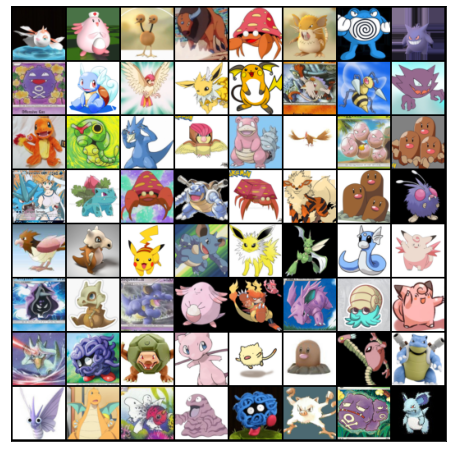

In [ ]:
#@title Denormalization, Display Image, Display Batch
# Removes the normalization procedure
def denormalize(img_tensors):
    return img_tensors * norm[1][0] + norm[0][0]

#Creates an 8x8 grid and displays our 64 images
def display_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denormalize(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

# Displays all 64 images of the dataloader
def display_batch(dl, nmax=64):
    for images, _ in dl:
        display_images(images, nmax)
        break

display_batch(train_dl)

### **GPU SETUP**

In [ ]:
#To use GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

train_dl = DeviceDataLoader(train_dl, device)

## **GAN Model**

In [ ]:
#@title Discriminator Model
# Discriminator
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    # Upsampling
    nn.Conv2d(3, image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, image_size * 2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size * 2),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, image_size * 4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size * 4),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, image_size * 8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size * 8),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(image_size * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

#To ensure the GPU can use it if one is present
discriminator = to_device(discriminator, device)

In [ ]:
#@title Generator Model
latent_dim = 128 #@param {type:"integer"}

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    # Downsampling
    nn.ConvTranspose2d(latent_dim, image_size * 8, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(image_size * 8),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size * 4),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size * 2),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(image_size, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

## **Training**

In [ ]:
#@title Train the Discriminator
def train_discriminator(real_images, optimizer_d):
    # Gradient is cleared
    optimizer_d.zero_grad()

    # Pass real images through discriminator
    predictions_r = discriminator(real_images)
    targets_r = torch.ones(real_images.size(0), 1, device=device)
    loss_r = F.binary_cross_entropy(predictions_r, targets_r)
    score_r = torch.mean(predictions_r).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_imgs = generator(latent)

    # Pass fake images through discriminator
    targets_f = torch.zeros(fake_imgs.size(0), 1, device=device)
    predictions_f = discriminator(fake_imgs)
    loss_f = F.binary_cross_entropy(predictions_f, targets_f)
    score_f = torch.mean(predictions_f).item()

    # Update weights
    loss = loss_r + loss_f
    loss.backward()
    optimizer_d.step()
    return loss.item(), score_r, score_f

In [ ]:
#@title Train the Generator
def train_generator(opt_g):
    # Gradient is cleared
    opt_g.zero_grad()
    
    # Noise is generated for the fake images
    latent = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_imgs = generator(latent)
    
    # Fake image is given to the Discriminator
    predictions = discriminator(fake_imgs)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(predictions, targets)
    
    # Update weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

#To ensure the GPU can use it if one is present
generator = to_device(generator, device)

Saving : generated-pokemon-0000.png


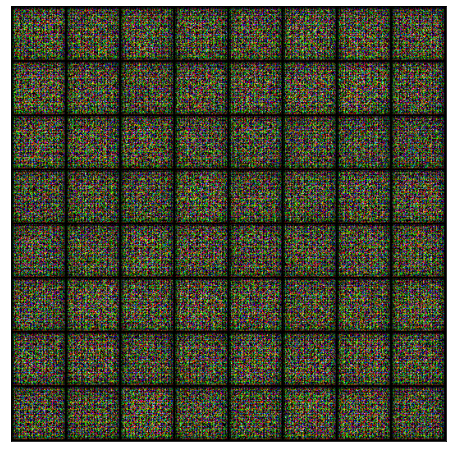

In [ ]:
#@title Save Generated Images
#Create a directory for our generated images
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

#Saves each iteration of the noise generation
def save(index, latent_tensors, show=True):
    images_f = generator(latent_tensors)
    file_f = 'generated-pokemon-{0:0=4d}.png'.format(index)
    save_image(denormalize(images_f), os.path.join(sample_dir, file_f), nrow=8)
    print('Saving :', file_f)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images_f.cpu().detach(), nrow=8).permute(1, 2, 0))

fixed_latent = torch.randn(64, latent_dim, 1, 1, device=device)
save(0, fixed_latent)

In [ ]:
#@title Train GAN
# Method to train the GAN, accepts epoch, learning rate, and start index as parameters
def generate(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    glosses = []
    dlosses = []
    real = []
    fake = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999)) #changed from 0.35, 0.999
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999)) #changed from 0.35, 0.999
    
    for epoch in range(epochs):
        for images_r, _ in tqdm(train_dl):
            # Train discriminator
            dloss, rscore, fscore = train_discriminator(images_r, opt_d)
            # Train generator
            gloss = train_generator(opt_g)
            
        # Record losses & scores
        glosses.append(gloss)
        dlosses.append(dloss)
        real.append(rscore)
        fake.append(fscore)
        
        # Log losses & scores (last batch)
        print(f"Epoch [{epoch+1}/{epochs}], generator loss: {gloss:.4f}, discriminator loss: {dloss:.4f}, real rating: {rscore:.4f}, fake rating: {fscore:.4f}")
    
        # Save generated images
        save(epoch+start_idx, fixed_latent, show=False)
    
    return glosses, dlosses, real, fake

*For faster but less accurate results, set the learning rate to .0002 and epochs to 100 (visuals will suffer as a result)*

In [ ]:
#@title Train

#Learning Rate
lr = 0.0002 #@param 

#Iterations during training
epochs = 400 #@param {type:"slider", min:100, max:1000, step:100}

#Run the trainer
history = generate(epochs, lr)

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [1/400], generator loss: 4.6498, discriminator loss: 0.1498, real rating: 0.9067, fake rating: 0.0467
Saving : generated-pokemon-0001.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [2/400], generator loss: 3.0186, discriminator loss: 0.3631, real rating: 0.8261, fake rating: 0.1442
Saving : generated-pokemon-0002.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [3/400], generator loss: 1.0502, discriminator loss: 1.4768, real rating: 0.4159, fake rating: 0.1634
Saving : generated-pokemon-0003.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [4/400], generator loss: 3.0658, discriminator loss: 0.4379, real rating: 0.7207, fake rating: 0.0631
Saving : generated-pokemon-0004.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [5/400], generator loss: 2.8799, discriminator loss: 0.7293, real rating: 0.6006, fake rating: 0.1159
Saving : generated-pokemon-0005.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [6/400], generator loss: 2.6121, discriminator loss: 0.5522, real rating: 0.8294, fake rating: 0.2924
Saving : generated-pokemon-0006.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [7/400], generator loss: 2.9414, discriminator loss: 0.2094, real rating: 0.8627, fake rating: 0.0456
Saving : generated-pokemon-0007.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [8/400], generator loss: 3.9377, discriminator loss: 0.5676, real rating: 0.6276, fake rating: 0.0382
Saving : generated-pokemon-0008.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [9/400], generator loss: 3.8941, discriminator loss: 0.7331, real rating: 0.8862, fake rating: 0.3919
Saving : generated-pokemon-0009.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [10/400], generator loss: 5.9143, discriminator loss: 0.9106, real rating: 0.9181, fake rating: 0.4923
Saving : generated-pokemon-0010.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [11/400], generator loss: 2.6696, discriminator loss: 0.4635, real rating: 0.7380, fake rating: 0.1059
Saving : generated-pokemon-0011.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [12/400], generator loss: 3.6951, discriminator loss: 0.4642, real rating: 0.9057, fake rating: 0.2805
Saving : generated-pokemon-0012.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [13/400], generator loss: 2.5402, discriminator loss: 0.5008, real rating: 0.8734, fake rating: 0.2625
Saving : generated-pokemon-0013.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [14/400], generator loss: 5.1616, discriminator loss: 0.6184, real rating: 0.9417, fake rating: 0.3927
Saving : generated-pokemon-0014.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [15/400], generator loss: 6.2865, discriminator loss: 0.7945, real rating: 0.9335, fake rating: 0.4552
Saving : generated-pokemon-0015.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [16/400], generator loss: 4.4987, discriminator loss: 0.2827, real rating: 0.7981, fake rating: 0.0345
Saving : generated-pokemon-0016.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [17/400], generator loss: 4.2181, discriminator loss: 0.3807, real rating: 0.8518, fake rating: 0.1773
Saving : generated-pokemon-0017.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [18/400], generator loss: 3.2454, discriminator loss: 0.3961, real rating: 0.7905, fake rating: 0.1139
Saving : generated-pokemon-0018.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [19/400], generator loss: 2.1946, discriminator loss: 0.4099, real rating: 0.7820, fake rating: 0.1259
Saving : generated-pokemon-0019.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [20/400], generator loss: 4.5117, discriminator loss: 0.2692, real rating: 0.9117, fake rating: 0.1485
Saving : generated-pokemon-0020.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [21/400], generator loss: 2.3676, discriminator loss: 0.5750, real rating: 0.7046, fake rating: 0.1472
Saving : generated-pokemon-0021.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [22/400], generator loss: 3.8851, discriminator loss: 0.4793, real rating: 0.9779, fake rating: 0.3205
Saving : generated-pokemon-0022.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [23/400], generator loss: 4.6182, discriminator loss: 0.5160, real rating: 0.8852, fake rating: 0.2990
Saving : generated-pokemon-0023.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [24/400], generator loss: 2.1261, discriminator loss: 1.0017, real rating: 0.4410, fake rating: 0.0233
Saving : generated-pokemon-0024.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [25/400], generator loss: 2.8676, discriminator loss: 0.6900, real rating: 0.7196, fake rating: 0.2490
Saving : generated-pokemon-0025.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [26/400], generator loss: 4.1595, discriminator loss: 0.3788, real rating: 0.9085, fake rating: 0.2299
Saving : generated-pokemon-0026.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [27/400], generator loss: 3.4382, discriminator loss: 0.5297, real rating: 0.8259, fake rating: 0.2586
Saving : generated-pokemon-0027.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [28/400], generator loss: 4.1282, discriminator loss: 0.3999, real rating: 0.9587, fake rating: 0.2775
Saving : generated-pokemon-0028.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [29/400], generator loss: 1.6012, discriminator loss: 2.3121, real rating: 0.1410, fake rating: 0.0071
Saving : generated-pokemon-0029.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [30/400], generator loss: 2.2159, discriminator loss: 0.3405, real rating: 0.8652, fake rating: 0.1594
Saving : generated-pokemon-0030.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [31/400], generator loss: 4.1300, discriminator loss: 0.4658, real rating: 0.8826, fake rating: 0.2643
Saving : generated-pokemon-0031.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [32/400], generator loss: 3.1946, discriminator loss: 0.5173, real rating: 0.6564, fake rating: 0.0119
Saving : generated-pokemon-0032.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [33/400], generator loss: 3.8377, discriminator loss: 0.5045, real rating: 0.9041, fake rating: 0.2837
Saving : generated-pokemon-0033.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [34/400], generator loss: 1.3563, discriminator loss: 0.6120, real rating: 0.6008, fake rating: 0.0531
Saving : generated-pokemon-0034.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [35/400], generator loss: 0.9667, discriminator loss: 1.1746, real rating: 0.3786, fake rating: 0.0040
Saving : generated-pokemon-0035.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [36/400], generator loss: 2.3877, discriminator loss: 0.7650, real rating: 0.5302, fake rating: 0.0148
Saving : generated-pokemon-0036.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [37/400], generator loss: 4.0258, discriminator loss: 0.2998, real rating: 0.9606, fake rating: 0.2119
Saving : generated-pokemon-0037.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [38/400], generator loss: 3.8897, discriminator loss: 0.3638, real rating: 0.9237, fake rating: 0.2249
Saving : generated-pokemon-0038.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [39/400], generator loss: 4.3499, discriminator loss: 0.5197, real rating: 0.9055, fake rating: 0.3036
Saving : generated-pokemon-0039.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [40/400], generator loss: 3.5943, discriminator loss: 0.3264, real rating: 0.9021, fake rating: 0.1784
Saving : generated-pokemon-0040.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [41/400], generator loss: 0.7578, discriminator loss: 1.0745, real rating: 0.4378, fake rating: 0.0193
Saving : generated-pokemon-0041.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [42/400], generator loss: 4.3304, discriminator loss: 0.3042, real rating: 0.9710, fake rating: 0.2254
Saving : generated-pokemon-0042.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [43/400], generator loss: 6.4739, discriminator loss: 1.1683, real rating: 0.9964, fake rating: 0.5991
Saving : generated-pokemon-0043.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [44/400], generator loss: 1.2134, discriminator loss: 0.4429, real rating: 0.6954, fake rating: 0.0470
Saving : generated-pokemon-0044.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [45/400], generator loss: 2.0771, discriminator loss: 0.3964, real rating: 0.7308, fake rating: 0.0430
Saving : generated-pokemon-0045.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [46/400], generator loss: 3.8907, discriminator loss: 0.2945, real rating: 0.9601, fake rating: 0.2036
Saving : generated-pokemon-0046.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [47/400], generator loss: 2.3895, discriminator loss: 0.2535, real rating: 0.8509, fake rating: 0.0753
Saving : generated-pokemon-0047.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [48/400], generator loss: 0.8677, discriminator loss: 0.5229, real rating: 0.7166, fake rating: 0.1448
Saving : generated-pokemon-0048.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [49/400], generator loss: 3.2680, discriminator loss: 0.1984, real rating: 0.9094, fake rating: 0.0913
Saving : generated-pokemon-0049.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [50/400], generator loss: 3.6637, discriminator loss: 0.2540, real rating: 0.9215, fake rating: 0.1481
Saving : generated-pokemon-0050.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [51/400], generator loss: 2.4076, discriminator loss: 0.3615, real rating: 0.7739, fake rating: 0.0527
Saving : generated-pokemon-0051.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [52/400], generator loss: 0.4997, discriminator loss: 0.8801, real rating: 0.4933, fake rating: 0.0201
Saving : generated-pokemon-0052.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [53/400], generator loss: 4.9572, discriminator loss: 0.4397, real rating: 0.9519, fake rating: 0.2987
Saving : generated-pokemon-0053.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [54/400], generator loss: 3.9344, discriminator loss: 0.9328, real rating: 0.9132, fake rating: 0.4801
Saving : generated-pokemon-0054.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [55/400], generator loss: 2.8391, discriminator loss: 0.1795, real rating: 0.8832, fake rating: 0.0476
Saving : generated-pokemon-0055.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [56/400], generator loss: 3.2740, discriminator loss: 0.1807, real rating: 0.9019, fake rating: 0.0681
Saving : generated-pokemon-0056.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [57/400], generator loss: 2.6702, discriminator loss: 0.3589, real rating: 0.8079, fake rating: 0.1008
Saving : generated-pokemon-0057.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [58/400], generator loss: 3.3822, discriminator loss: 0.1675, real rating: 0.9257, fake rating: 0.0815
Saving : generated-pokemon-0058.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [59/400], generator loss: 3.1154, discriminator loss: 0.1775, real rating: 0.9141, fake rating: 0.0753
Saving : generated-pokemon-0059.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [60/400], generator loss: 1.4561, discriminator loss: 0.4229, real rating: 0.7225, fake rating: 0.0486
Saving : generated-pokemon-0060.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [61/400], generator loss: 3.3967, discriminator loss: 0.2997, real rating: 0.9060, fake rating: 0.1600
Saving : generated-pokemon-0061.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [62/400], generator loss: 3.2801, discriminator loss: 0.2630, real rating: 0.9245, fake rating: 0.1473
Saving : generated-pokemon-0062.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [63/400], generator loss: 3.5643, discriminator loss: 0.1323, real rating: 0.9183, fake rating: 0.0429
Saving : generated-pokemon-0063.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [64/400], generator loss: 6.0815, discriminator loss: 0.1603, real rating: 0.8928, fake rating: 0.0222
Saving : generated-pokemon-0064.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [65/400], generator loss: 1.2133, discriminator loss: 0.8254, real rating: 0.5136, fake rating: 0.0088
Saving : generated-pokemon-0065.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [66/400], generator loss: 3.6396, discriminator loss: 0.1475, real rating: 0.8826, fake rating: 0.0156
Saving : generated-pokemon-0066.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [67/400], generator loss: 7.3510, discriminator loss: 0.5084, real rating: 0.9925, fake rating: 0.3425
Saving : generated-pokemon-0067.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [68/400], generator loss: 2.1627, discriminator loss: 0.2165, real rating: 0.8863, fake rating: 0.0767
Saving : generated-pokemon-0068.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [69/400], generator loss: 0.2616, discriminator loss: 2.2879, real rating: 0.1950, fake rating: 0.0037
Saving : generated-pokemon-0069.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [70/400], generator loss: 2.3166, discriminator loss: 0.2958, real rating: 0.8661, fake rating: 0.1278
Saving : generated-pokemon-0070.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [71/400], generator loss: 5.1539, discriminator loss: 0.2665, real rating: 0.8123, fake rating: 0.0175
Saving : generated-pokemon-0071.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [72/400], generator loss: 5.9287, discriminator loss: 0.4350, real rating: 0.9863, fake rating: 0.3111
Saving : generated-pokemon-0072.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [73/400], generator loss: 3.4259, discriminator loss: 0.1327, real rating: 0.9023, fake rating: 0.0241
Saving : generated-pokemon-0073.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [74/400], generator loss: 3.7690, discriminator loss: 0.1550, real rating: 0.9755, fake rating: 0.1118
Saving : generated-pokemon-0074.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [75/400], generator loss: 3.9825, discriminator loss: 0.1377, real rating: 0.9841, fake rating: 0.1053
Saving : generated-pokemon-0075.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [76/400], generator loss: 5.7296, discriminator loss: 0.2450, real rating: 0.9927, fake rating: 0.1953
Saving : generated-pokemon-0076.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [77/400], generator loss: 2.3906, discriminator loss: 0.2954, real rating: 0.8420, fake rating: 0.0937
Saving : generated-pokemon-0077.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [78/400], generator loss: 4.5190, discriminator loss: 0.1958, real rating: 0.9704, fake rating: 0.1378
Saving : generated-pokemon-0078.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [79/400], generator loss: 3.5249, discriminator loss: 0.4028, real rating: 0.8860, fake rating: 0.2032
Saving : generated-pokemon-0079.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [80/400], generator loss: 3.2670, discriminator loss: 0.1682, real rating: 0.9302, fake rating: 0.0779
Saving : generated-pokemon-0080.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [81/400], generator loss: 3.0871, discriminator loss: 0.1231, real rating: 0.9214, fake rating: 0.0366
Saving : generated-pokemon-0081.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [82/400], generator loss: 3.1336, discriminator loss: 0.1279, real rating: 0.9172, fake rating: 0.0376
Saving : generated-pokemon-0082.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [83/400], generator loss: 2.3302, discriminator loss: 0.8237, real rating: 0.5402, fake rating: 0.0219
Saving : generated-pokemon-0083.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [84/400], generator loss: 1.1307, discriminator loss: 0.3915, real rating: 0.7714, fake rating: 0.0870
Saving : generated-pokemon-0084.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [85/400], generator loss: 4.0006, discriminator loss: 0.2410, real rating: 0.9840, fake rating: 0.1823
Saving : generated-pokemon-0085.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [86/400], generator loss: 3.2504, discriminator loss: 0.5796, real rating: 0.7600, fake rating: 0.1913
Saving : generated-pokemon-0086.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [87/400], generator loss: 3.6655, discriminator loss: 0.1610, real rating: 0.9719, fake rating: 0.1125
Saving : generated-pokemon-0087.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [88/400], generator loss: 8.3210, discriminator loss: 1.8724, real rating: 0.9966, fake rating: 0.7315
Saving : generated-pokemon-0088.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [89/400], generator loss: 3.9194, discriminator loss: 0.0974, real rating: 0.9451, fake rating: 0.0365
Saving : generated-pokemon-0089.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [90/400], generator loss: 5.1463, discriminator loss: 0.1768, real rating: 0.9904, fake rating: 0.1392
Saving : generated-pokemon-0090.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [91/400], generator loss: 4.0815, discriminator loss: 0.1102, real rating: 0.9172, fake rating: 0.0193
Saving : generated-pokemon-0091.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [92/400], generator loss: 3.5152, discriminator loss: 0.5663, real rating: 0.7573, fake rating: 0.1556
Saving : generated-pokemon-0092.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [93/400], generator loss: 4.5498, discriminator loss: 0.2196, real rating: 0.9489, fake rating: 0.1371
Saving : generated-pokemon-0093.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [94/400], generator loss: 5.0090, discriminator loss: 0.1755, real rating: 0.9976, fake rating: 0.1467
Saving : generated-pokemon-0094.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [95/400], generator loss: 4.6508, discriminator loss: 0.1238, real rating: 0.9977, fake rating: 0.1048
Saving : generated-pokemon-0095.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [96/400], generator loss: 1.0296, discriminator loss: 0.3095, real rating: 0.7595, fake rating: 0.0118
Saving : generated-pokemon-0096.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [97/400], generator loss: 3.2036, discriminator loss: 0.1776, real rating: 0.9000, fake rating: 0.0595
Saving : generated-pokemon-0097.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [98/400], generator loss: 1.6366, discriminator loss: 0.2481, real rating: 0.8415, fake rating: 0.0480
Saving : generated-pokemon-0098.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [99/400], generator loss: 3.2992, discriminator loss: 0.1231, real rating: 0.9371, fake rating: 0.0533
Saving : generated-pokemon-0099.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [100/400], generator loss: 3.8152, discriminator loss: 0.1116, real rating: 0.9353, fake rating: 0.0370
Saving : generated-pokemon-0100.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [101/400], generator loss: 4.2169, discriminator loss: 0.0749, real rating: 0.9778, fake rating: 0.0494
Saving : generated-pokemon-0101.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [102/400], generator loss: 3.2415, discriminator loss: 0.1186, real rating: 0.9457, fake rating: 0.0540
Saving : generated-pokemon-0102.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [103/400], generator loss: 2.2393, discriminator loss: 0.2252, real rating: 0.8405, fake rating: 0.0403
Saving : generated-pokemon-0103.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [104/400], generator loss: 2.7333, discriminator loss: 0.1735, real rating: 0.8783, fake rating: 0.0334
Saving : generated-pokemon-0104.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [105/400], generator loss: 3.0415, discriminator loss: 0.0929, real rating: 0.9473, fake rating: 0.0349
Saving : generated-pokemon-0105.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [106/400], generator loss: 4.2430, discriminator loss: 0.0603, real rating: 0.9767, fake rating: 0.0336
Saving : generated-pokemon-0106.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [107/400], generator loss: 4.3745, discriminator loss: 0.1180, real rating: 0.9645, fake rating: 0.0739
Saving : generated-pokemon-0107.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [108/400], generator loss: 2.5910, discriminator loss: 0.3780, real rating: 0.8446, fake rating: 0.1497
Saving : generated-pokemon-0108.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [109/400], generator loss: 2.3278, discriminator loss: 0.3260, real rating: 0.7976, fake rating: 0.0543
Saving : generated-pokemon-0109.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [110/400], generator loss: 3.9067, discriminator loss: 0.1089, real rating: 0.9928, fake rating: 0.0898
Saving : generated-pokemon-0110.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [111/400], generator loss: 4.7748, discriminator loss: 0.1035, real rating: 0.9889, fake rating: 0.0819
Saving : generated-pokemon-0111.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [112/400], generator loss: 1.6366, discriminator loss: 1.2446, real rating: 0.5067, fake rating: 0.0973
Saving : generated-pokemon-0112.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [113/400], generator loss: 4.2485, discriminator loss: 0.1114, real rating: 0.9597, fake rating: 0.0614
Saving : generated-pokemon-0113.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [114/400], generator loss: 4.3303, discriminator loss: 0.0953, real rating: 0.9511, fake rating: 0.0409
Saving : generated-pokemon-0114.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [115/400], generator loss: 4.5502, discriminator loss: 0.0609, real rating: 0.9749, fake rating: 0.0335
Saving : generated-pokemon-0115.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [116/400], generator loss: 4.4292, discriminator loss: 0.0839, real rating: 0.9437, fake rating: 0.0227
Saving : generated-pokemon-0116.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [117/400], generator loss: 3.8331, discriminator loss: 0.3423, real rating: 0.8979, fake rating: 0.1649
Saving : generated-pokemon-0117.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [118/400], generator loss: 4.3129, discriminator loss: 0.0924, real rating: 0.9837, fake rating: 0.0678
Saving : generated-pokemon-0118.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [119/400], generator loss: 3.4363, discriminator loss: 0.1031, real rating: 0.9280, fake rating: 0.0258
Saving : generated-pokemon-0119.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [120/400], generator loss: 3.9488, discriminator loss: 0.0700, real rating: 0.9602, fake rating: 0.0275
Saving : generated-pokemon-0120.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [121/400], generator loss: 5.1882, discriminator loss: 0.0425, real rating: 0.9682, fake rating: 0.0098
Saving : generated-pokemon-0121.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [122/400], generator loss: 3.2982, discriminator loss: 0.1031, real rating: 0.9132, fake rating: 0.0090
Saving : generated-pokemon-0122.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [123/400], generator loss: 4.3030, discriminator loss: 0.0647, real rating: 0.9443, fake rating: 0.0063
Saving : generated-pokemon-0123.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [124/400], generator loss: 4.6748, discriminator loss: 0.0454, real rating: 0.9706, fake rating: 0.0149
Saving : generated-pokemon-0124.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [125/400], generator loss: 0.6337, discriminator loss: 0.2009, real rating: 0.8429, fake rating: 0.0123
Saving : generated-pokemon-0125.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [126/400], generator loss: 4.1113, discriminator loss: 0.2408, real rating: 0.9230, fake rating: 0.1257
Saving : generated-pokemon-0126.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [127/400], generator loss: 2.9710, discriminator loss: 0.1810, real rating: 0.8866, fake rating: 0.0478
Saving : generated-pokemon-0127.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [128/400], generator loss: 4.4037, discriminator loss: 0.0638, real rating: 0.9791, fake rating: 0.0405
Saving : generated-pokemon-0128.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [129/400], generator loss: 0.1996, discriminator loss: 5.9293, real rating: 0.0148, fake rating: 0.0003
Saving : generated-pokemon-0129.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [130/400], generator loss: 4.6655, discriminator loss: 0.2022, real rating: 0.8557, fake rating: 0.0291
Saving : generated-pokemon-0130.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [131/400], generator loss: 1.7602, discriminator loss: 0.2877, real rating: 0.7880, fake rating: 0.0262
Saving : generated-pokemon-0131.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [132/400], generator loss: 4.9528, discriminator loss: 0.0829, real rating: 0.9857, fake rating: 0.0590
Saving : generated-pokemon-0132.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [133/400], generator loss: 2.2959, discriminator loss: 0.1641, real rating: 0.8705, fake rating: 0.0163
Saving : generated-pokemon-0133.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [134/400], generator loss: 4.6692, discriminator loss: 0.0403, real rating: 0.9755, fake rating: 0.0146
Saving : generated-pokemon-0134.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [135/400], generator loss: 5.2081, discriminator loss: 0.0492, real rating: 0.9865, fake rating: 0.0333
Saving : generated-pokemon-0135.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [136/400], generator loss: 5.4273, discriminator loss: 0.0276, real rating: 0.9927, fake rating: 0.0196
Saving : generated-pokemon-0136.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [137/400], generator loss: 3.5447, discriminator loss: 0.7172, real rating: 0.8041, fake rating: 0.3119
Saving : generated-pokemon-0137.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [138/400], generator loss: 2.5071, discriminator loss: 0.3451, real rating: 0.9728, fake rating: 0.2409
Saving : generated-pokemon-0138.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [139/400], generator loss: 3.5157, discriminator loss: 0.1426, real rating: 0.8890, fake rating: 0.0182
Saving : generated-pokemon-0139.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [140/400], generator loss: 4.9012, discriminator loss: 0.0599, real rating: 0.9549, fake rating: 0.0124
Saving : generated-pokemon-0140.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [141/400], generator loss: 3.1704, discriminator loss: 0.1325, real rating: 0.9178, fake rating: 0.0383
Saving : generated-pokemon-0141.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [142/400], generator loss: 4.5058, discriminator loss: 0.0594, real rating: 0.9583, fake rating: 0.0157
Saving : generated-pokemon-0142.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [143/400], generator loss: 5.0089, discriminator loss: 0.0358, real rating: 0.9838, fake rating: 0.0187
Saving : generated-pokemon-0143.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [144/400], generator loss: 3.3969, discriminator loss: 0.3367, real rating: 0.9298, fake rating: 0.1975
Saving : generated-pokemon-0144.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [145/400], generator loss: 2.1520, discriminator loss: 0.2975, real rating: 0.7805, fake rating: 0.0182
Saving : generated-pokemon-0145.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [146/400], generator loss: 3.7881, discriminator loss: 0.1029, real rating: 0.9304, fake rating: 0.0257
Saving : generated-pokemon-0146.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [147/400], generator loss: 3.6998, discriminator loss: 0.1132, real rating: 0.9346, fake rating: 0.0396
Saving : generated-pokemon-0147.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [148/400], generator loss: 3.2509, discriminator loss: 0.0849, real rating: 0.9400, fake rating: 0.0208
Saving : generated-pokemon-0148.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [149/400], generator loss: 4.3062, discriminator loss: 0.0611, real rating: 0.9521, fake rating: 0.0102
Saving : generated-pokemon-0149.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [150/400], generator loss: 1.7009, discriminator loss: 1.1660, real rating: 0.5232, fake rating: 0.1229
Saving : generated-pokemon-0150.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [151/400], generator loss: 3.2629, discriminator loss: 0.2041, real rating: 0.8638, fake rating: 0.0438
Saving : generated-pokemon-0151.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [152/400], generator loss: 4.4167, discriminator loss: 0.0751, real rating: 0.9888, fake rating: 0.0584
Saving : generated-pokemon-0152.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [153/400], generator loss: 3.2237, discriminator loss: 0.1054, real rating: 0.9379, fake rating: 0.0323
Saving : generated-pokemon-0153.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [154/400], generator loss: 4.7009, discriminator loss: 0.0386, real rating: 0.9747, fake rating: 0.0125
Saving : generated-pokemon-0154.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [155/400], generator loss: 5.6360, discriminator loss: 0.0334, real rating: 0.9754, fake rating: 0.0080
Saving : generated-pokemon-0155.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [156/400], generator loss: 5.4755, discriminator loss: 0.0629, real rating: 0.9908, fake rating: 0.0491
Saving : generated-pokemon-0156.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [157/400], generator loss: 5.6258, discriminator loss: 0.0463, real rating: 0.9855, fake rating: 0.0303
Saving : generated-pokemon-0157.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [158/400], generator loss: 3.2644, discriminator loss: 0.1055, real rating: 0.9097, fake rating: 0.0075
Saving : generated-pokemon-0158.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [159/400], generator loss: 2.6874, discriminator loss: 0.3270, real rating: 0.7668, fake rating: 0.0215
Saving : generated-pokemon-0159.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [160/400], generator loss: 5.0204, discriminator loss: 0.0513, real rating: 0.9775, fake rating: 0.0270
Saving : generated-pokemon-0160.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [161/400], generator loss: 3.0631, discriminator loss: 0.1353, real rating: 0.9081, fake rating: 0.0257
Saving : generated-pokemon-0161.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [162/400], generator loss: 5.8151, discriminator loss: 0.0247, real rating: 0.9945, fake rating: 0.0183
Saving : generated-pokemon-0162.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [163/400], generator loss: 5.4015, discriminator loss: 0.0771, real rating: 0.9946, fake rating: 0.0649
Saving : generated-pokemon-0163.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [164/400], generator loss: 4.9309, discriminator loss: 0.0449, real rating: 0.9809, fake rating: 0.0240
Saving : generated-pokemon-0164.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [165/400], generator loss: 6.1329, discriminator loss: 0.0287, real rating: 0.9761, fake rating: 0.0043
Saving : generated-pokemon-0165.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [166/400], generator loss: 3.7617, discriminator loss: 0.0725, real rating: 0.9485, fake rating: 0.0179
Saving : generated-pokemon-0166.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [167/400], generator loss: 6.1691, discriminator loss: 0.0480, real rating: 0.9983, fake rating: 0.0424
Saving : generated-pokemon-0167.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [168/400], generator loss: 6.4126, discriminator loss: 0.0311, real rating: 0.9970, fake rating: 0.0268
Saving : generated-pokemon-0168.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [169/400], generator loss: 4.5185, discriminator loss: 0.0440, real rating: 0.9698, fake rating: 0.0126
Saving : generated-pokemon-0169.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [170/400], generator loss: 0.2536, discriminator loss: 9.5680, real rating: 0.0002, fake rating: 0.0000
Saving : generated-pokemon-0170.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [171/400], generator loss: 4.2198, discriminator loss: 0.3632, real rating: 0.9813, fake rating: 0.2365
Saving : generated-pokemon-0171.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [172/400], generator loss: 4.8521, discriminator loss: 0.1232, real rating: 0.9849, fake rating: 0.0852
Saving : generated-pokemon-0172.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [173/400], generator loss: 2.9929, discriminator loss: 0.0661, real rating: 0.9626, fake rating: 0.0257
Saving : generated-pokemon-0173.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [174/400], generator loss: 5.2876, discriminator loss: 0.0445, real rating: 0.9815, fake rating: 0.0245
Saving : generated-pokemon-0174.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [175/400], generator loss: 5.5347, discriminator loss: 0.0525, real rating: 0.9897, fake rating: 0.0369
Saving : generated-pokemon-0175.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [176/400], generator loss: 4.2266, discriminator loss: 0.0538, real rating: 0.9659, fake rating: 0.0176
Saving : generated-pokemon-0176.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [177/400], generator loss: 5.0943, discriminator loss: 0.0267, real rating: 0.9873, fake rating: 0.0135
Saving : generated-pokemon-0177.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [178/400], generator loss: 4.4200, discriminator loss: 0.0291, real rating: 0.9851, fake rating: 0.0135
Saving : generated-pokemon-0178.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [179/400], generator loss: 4.8845, discriminator loss: 0.0382, real rating: 0.9661, fake rating: 0.0030
Saving : generated-pokemon-0179.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [180/400], generator loss: 3.8680, discriminator loss: 0.0556, real rating: 0.9628, fake rating: 0.0163
Saving : generated-pokemon-0180.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [181/400], generator loss: 5.7339, discriminator loss: 0.0316, real rating: 0.9963, fake rating: 0.0262
Saving : generated-pokemon-0181.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [182/400], generator loss: 7.0300, discriminator loss: 0.0685, real rating: 0.9987, fake rating: 0.0612
Saving : generated-pokemon-0182.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [183/400], generator loss: 5.0167, discriminator loss: 0.5049, real rating: 0.8668, fake rating: 0.2234
Saving : generated-pokemon-0183.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [184/400], generator loss: 2.2783, discriminator loss: 0.2526, real rating: 0.8326, fake rating: 0.0282
Saving : generated-pokemon-0184.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [185/400], generator loss: 5.8553, discriminator loss: 0.1329, real rating: 0.9118, fake rating: 0.0252
Saving : generated-pokemon-0185.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [186/400], generator loss: 5.0751, discriminator loss: 0.0750, real rating: 0.9743, fake rating: 0.0411
Saving : generated-pokemon-0186.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [187/400], generator loss: 5.4667, discriminator loss: 0.0503, real rating: 0.9834, fake rating: 0.0320
Saving : generated-pokemon-0187.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [188/400], generator loss: 5.1979, discriminator loss: 0.0798, real rating: 0.9937, fake rating: 0.0648
Saving : generated-pokemon-0188.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [189/400], generator loss: 2.7219, discriminator loss: 0.8332, real rating: 0.6981, fake rating: 0.1903
Saving : generated-pokemon-0189.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [190/400], generator loss: 5.2438, discriminator loss: 0.1540, real rating: 0.9756, fake rating: 0.1048
Saving : generated-pokemon-0190.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [191/400], generator loss: 5.4903, discriminator loss: 0.1005, real rating: 0.9973, fake rating: 0.0866
Saving : generated-pokemon-0191.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [192/400], generator loss: 5.1242, discriminator loss: 0.0496, real rating: 0.9796, fake rating: 0.0265
Saving : generated-pokemon-0192.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [193/400], generator loss: 4.2079, discriminator loss: 0.0687, real rating: 0.9632, fake rating: 0.0292
Saving : generated-pokemon-0193.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [194/400], generator loss: 5.0228, discriminator loss: 0.0358, real rating: 0.9774, fake rating: 0.0121
Saving : generated-pokemon-0194.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [195/400], generator loss: 6.1910, discriminator loss: 0.0277, real rating: 0.9921, fake rating: 0.0189
Saving : generated-pokemon-0195.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [196/400], generator loss: 4.1254, discriminator loss: 0.0940, real rating: 0.9315, fake rating: 0.0202
Saving : generated-pokemon-0196.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [197/400], generator loss: 6.0653, discriminator loss: 0.0122, real rating: 0.9989, fake rating: 0.0108
Saving : generated-pokemon-0197.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [198/400], generator loss: 7.2735, discriminator loss: 0.0599, real rating: 0.9919, fake rating: 0.0464
Saving : generated-pokemon-0198.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [199/400], generator loss: 3.1933, discriminator loss: 0.0810, real rating: 0.9345, fake rating: 0.0102
Saving : generated-pokemon-0199.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [200/400], generator loss: 6.9644, discriminator loss: 0.0285, real rating: 0.9964, fake rating: 0.0231
Saving : generated-pokemon-0200.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [201/400], generator loss: 6.1031, discriminator loss: 0.0186, real rating: 0.9904, fake rating: 0.0086
Saving : generated-pokemon-0201.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [202/400], generator loss: 7.7600, discriminator loss: 0.0813, real rating: 0.9976, fake rating: 0.0710
Saving : generated-pokemon-0202.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [203/400], generator loss: 6.9223, discriminator loss: 0.0144, real rating: 0.9907, fake rating: 0.0049
Saving : generated-pokemon-0203.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [204/400], generator loss: 6.8495, discriminator loss: 0.0194, real rating: 0.9965, fake rating: 0.0150
Saving : generated-pokemon-0204.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [205/400], generator loss: 7.2077, discriminator loss: 0.7113, real rating: 0.9653, fake rating: 0.3676
Saving : generated-pokemon-0205.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [206/400], generator loss: 4.5695, discriminator loss: 0.1133, real rating: 0.9430, fake rating: 0.0462
Saving : generated-pokemon-0206.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [207/400], generator loss: 5.5592, discriminator loss: 0.0312, real rating: 0.9906, fake rating: 0.0207
Saving : generated-pokemon-0207.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [208/400], generator loss: 5.5809, discriminator loss: 0.0196, real rating: 0.9970, fake rating: 0.0161
Saving : generated-pokemon-0208.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [209/400], generator loss: 6.2267, discriminator loss: 0.0309, real rating: 0.9989, fake rating: 0.0283
Saving : generated-pokemon-0209.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [210/400], generator loss: 5.4347, discriminator loss: 0.0399, real rating: 0.9672, fake rating: 0.0058
Saving : generated-pokemon-0210.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [211/400], generator loss: 5.2899, discriminator loss: 0.0533, real rating: 0.9723, fake rating: 0.0228
Saving : generated-pokemon-0211.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [212/400], generator loss: 6.6627, discriminator loss: 0.0064, real rating: 0.9981, fake rating: 0.0045
Saving : generated-pokemon-0212.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [213/400], generator loss: 5.9145, discriminator loss: 0.0432, real rating: 0.9961, fake rating: 0.0368
Saving : generated-pokemon-0213.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [214/400], generator loss: 6.1701, discriminator loss: 0.6174, real rating: 0.9689, fake rating: 0.3354
Saving : generated-pokemon-0214.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [215/400], generator loss: 5.5902, discriminator loss: 0.0662, real rating: 0.9851, fake rating: 0.0422
Saving : generated-pokemon-0215.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [216/400], generator loss: 3.7962, discriminator loss: 0.0734, real rating: 0.9476, fake rating: 0.0166
Saving : generated-pokemon-0216.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [217/400], generator loss: 5.7190, discriminator loss: 0.0450, real rating: 0.9751, fake rating: 0.0185
Saving : generated-pokemon-0217.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [218/400], generator loss: 1.4716, discriminator loss: 5.6948, real rating: 0.0371, fake rating: 0.0035
Saving : generated-pokemon-0218.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [219/400], generator loss: 4.1567, discriminator loss: 0.1744, real rating: 0.9283, fake rating: 0.0620
Saving : generated-pokemon-0219.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [220/400], generator loss: 4.2221, discriminator loss: 0.1324, real rating: 0.8914, fake rating: 0.0070
Saving : generated-pokemon-0220.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [221/400], generator loss: 4.7916, discriminator loss: 0.0531, real rating: 0.9822, fake rating: 0.0330
Saving : generated-pokemon-0221.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [222/400], generator loss: 5.6570, discriminator loss: 0.0200, real rating: 0.9914, fake rating: 0.0111
Saving : generated-pokemon-0222.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [223/400], generator loss: 4.3465, discriminator loss: 0.0507, real rating: 0.9632, fake rating: 0.0120
Saving : generated-pokemon-0223.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [224/400], generator loss: 5.6858, discriminator loss: 0.0262, real rating: 0.9887, fake rating: 0.0145
Saving : generated-pokemon-0224.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [225/400], generator loss: 3.3135, discriminator loss: 0.0867, real rating: 0.9287, fake rating: 0.0088
Saving : generated-pokemon-0225.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [226/400], generator loss: 4.6903, discriminator loss: 0.0807, real rating: 0.9818, fake rating: 0.0546
Saving : generated-pokemon-0226.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [227/400], generator loss: 3.7320, discriminator loss: 0.0853, real rating: 0.9550, fake rating: 0.0358
Saving : generated-pokemon-0227.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [228/400], generator loss: 4.7847, discriminator loss: 0.0466, real rating: 0.9636, fake rating: 0.0086
Saving : generated-pokemon-0228.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [229/400], generator loss: 6.6446, discriminator loss: 0.0201, real rating: 0.9896, fake rating: 0.0087
Saving : generated-pokemon-0229.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [230/400], generator loss: 5.2061, discriminator loss: 0.0292, real rating: 0.9805, fake rating: 0.0089
Saving : generated-pokemon-0230.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [231/400], generator loss: 5.1283, discriminator loss: 0.0325, real rating: 0.9769, fake rating: 0.0087
Saving : generated-pokemon-0231.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [232/400], generator loss: 6.0325, discriminator loss: 0.0241, real rating: 0.9927, fake rating: 0.0162
Saving : generated-pokemon-0232.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [233/400], generator loss: 5.3805, discriminator loss: 0.0358, real rating: 0.9712, fake rating: 0.0049
Saving : generated-pokemon-0233.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [234/400], generator loss: 6.2151, discriminator loss: 0.0142, real rating: 0.9949, fake rating: 0.0089
Saving : generated-pokemon-0234.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [235/400], generator loss: 4.8164, discriminator loss: 0.0357, real rating: 0.9711, fake rating: 0.0059
Saving : generated-pokemon-0235.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [236/400], generator loss: 8.3155, discriminator loss: 0.0281, real rating: 0.9986, fake rating: 0.0251
Saving : generated-pokemon-0236.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [237/400], generator loss: 5.9561, discriminator loss: 0.0199, real rating: 0.9942, fake rating: 0.0135
Saving : generated-pokemon-0237.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [238/400], generator loss: 6.5027, discriminator loss: 0.0194, real rating: 0.9846, fake rating: 0.0037
Saving : generated-pokemon-0238.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [239/400], generator loss: 6.5869, discriminator loss: 0.0111, real rating: 0.9958, fake rating: 0.0068
Saving : generated-pokemon-0239.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [240/400], generator loss: 3.5645, discriminator loss: 0.3430, real rating: 0.8334, fake rating: 0.0519
Saving : generated-pokemon-0240.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [241/400], generator loss: 5.5463, discriminator loss: 0.0808, real rating: 0.9834, fake rating: 0.0527
Saving : generated-pokemon-0241.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [242/400], generator loss: 4.9779, discriminator loss: 0.1435, real rating: 0.8935, fake rating: 0.0068
Saving : generated-pokemon-0242.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [243/400], generator loss: 4.4599, discriminator loss: 0.0437, real rating: 0.9694, fake rating: 0.0103
Saving : generated-pokemon-0243.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [244/400], generator loss: 6.9243, discriminator loss: 0.0176, real rating: 0.9938, fake rating: 0.0111
Saving : generated-pokemon-0244.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [245/400], generator loss: 5.4043, discriminator loss: 0.0184, real rating: 0.9913, fake rating: 0.0092
Saving : generated-pokemon-0245.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [246/400], generator loss: 2.5113, discriminator loss: 0.0691, real rating: 0.9483, fake rating: 0.0056
Saving : generated-pokemon-0246.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [247/400], generator loss: 4.3586, discriminator loss: 0.2478, real rating: 0.8569, fake rating: 0.0224
Saving : generated-pokemon-0247.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [248/400], generator loss: 4.8042, discriminator loss: 0.2238, real rating: 0.9972, fake rating: 0.1685
Saving : generated-pokemon-0248.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [249/400], generator loss: 5.5004, discriminator loss: 0.0319, real rating: 0.9867, fake rating: 0.0180
Saving : generated-pokemon-0249.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [250/400], generator loss: 5.5407, discriminator loss: 0.0400, real rating: 0.9826, fake rating: 0.0211
Saving : generated-pokemon-0250.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [251/400], generator loss: 4.7527, discriminator loss: 0.0371, real rating: 0.9736, fake rating: 0.0098
Saving : generated-pokemon-0251.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [252/400], generator loss: 4.3378, discriminator loss: 0.0492, real rating: 0.9693, fake rating: 0.0165
Saving : generated-pokemon-0252.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [253/400], generator loss: 5.7907, discriminator loss: 0.0234, real rating: 0.9928, fake rating: 0.0154
Saving : generated-pokemon-0253.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [254/400], generator loss: 4.8247, discriminator loss: 0.0471, real rating: 0.9610, fake rating: 0.0061
Saving : generated-pokemon-0254.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [255/400], generator loss: 4.0245, discriminator loss: 0.0621, real rating: 0.9485, fake rating: 0.0074
Saving : generated-pokemon-0255.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [256/400], generator loss: 5.5278, discriminator loss: 0.0377, real rating: 0.9673, fake rating: 0.0029
Saving : generated-pokemon-0256.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [257/400], generator loss: 6.2794, discriminator loss: 0.0125, real rating: 0.9980, fake rating: 0.0103
Saving : generated-pokemon-0257.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [258/400], generator loss: 6.3599, discriminator loss: 0.0283, real rating: 0.9828, fake rating: 0.0104
Saving : generated-pokemon-0258.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [259/400], generator loss: 5.4465, discriminator loss: 0.5567, real rating: 0.9366, fake rating: 0.2676
Saving : generated-pokemon-0259.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [260/400], generator loss: 5.6075, discriminator loss: 0.1353, real rating: 0.9199, fake rating: 0.0406
Saving : generated-pokemon-0260.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [261/400], generator loss: 4.7524, discriminator loss: 0.0791, real rating: 0.9419, fake rating: 0.0145
Saving : generated-pokemon-0261.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [262/400], generator loss: 5.1198, discriminator loss: 0.0390, real rating: 0.9774, fake rating: 0.0152
Saving : generated-pokemon-0262.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [263/400], generator loss: 5.7203, discriminator loss: 0.0260, real rating: 0.9869, fake rating: 0.0123
Saving : generated-pokemon-0263.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [264/400], generator loss: 5.5581, discriminator loss: 0.0204, real rating: 0.9858, fake rating: 0.0058
Saving : generated-pokemon-0264.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [265/400], generator loss: 5.8211, discriminator loss: 0.0148, real rating: 0.9914, fake rating: 0.0060
Saving : generated-pokemon-0265.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [266/400], generator loss: 6.0277, discriminator loss: 0.0154, real rating: 0.9885, fake rating: 0.0038
Saving : generated-pokemon-0266.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [267/400], generator loss: 4.5239, discriminator loss: 0.7235, real rating: 0.8662, fake rating: 0.3013
Saving : generated-pokemon-0267.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [268/400], generator loss: 3.6283, discriminator loss: 0.1245, real rating: 0.9064, fake rating: 0.0159
Saving : generated-pokemon-0268.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [269/400], generator loss: 6.5019, discriminator loss: 0.0152, real rating: 0.9941, fake rating: 0.0091
Saving : generated-pokemon-0269.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [270/400], generator loss: 5.6302, discriminator loss: 0.0460, real rating: 0.9811, fake rating: 0.0254
Saving : generated-pokemon-0270.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [271/400], generator loss: 6.9031, discriminator loss: 0.0202, real rating: 0.9859, fake rating: 0.0056
Saving : generated-pokemon-0271.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [272/400], generator loss: 6.0233, discriminator loss: 0.0318, real rating: 0.9746, fake rating: 0.0052
Saving : generated-pokemon-0272.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [273/400], generator loss: 6.1569, discriminator loss: 0.0209, real rating: 0.9899, fake rating: 0.0105
Saving : generated-pokemon-0273.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [274/400], generator loss: 6.5897, discriminator loss: 0.0304, real rating: 0.9971, fake rating: 0.0244
Saving : generated-pokemon-0274.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [275/400], generator loss: 7.2580, discriminator loss: 0.0205, real rating: 0.9953, fake rating: 0.0153
Saving : generated-pokemon-0275.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [276/400], generator loss: 5.7699, discriminator loss: 0.0112, real rating: 0.9970, fake rating: 0.0081
Saving : generated-pokemon-0276.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [277/400], generator loss: 4.9698, discriminator loss: 0.0290, real rating: 0.9772, fake rating: 0.0055
Saving : generated-pokemon-0277.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [278/400], generator loss: 6.6641, discriminator loss: 0.0086, real rating: 0.9957, fake rating: 0.0041
Saving : generated-pokemon-0278.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [279/400], generator loss: 2.4985, discriminator loss: 0.0697, real rating: 0.9418, fake rating: 0.0069
Saving : generated-pokemon-0279.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [280/400], generator loss: 5.1535, discriminator loss: 0.1328, real rating: 0.9743, fake rating: 0.0813
Saving : generated-pokemon-0280.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [281/400], generator loss: 4.0342, discriminator loss: 0.0879, real rating: 0.9513, fake rating: 0.0326
Saving : generated-pokemon-0281.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [282/400], generator loss: 5.0380, discriminator loss: 0.0493, real rating: 0.9742, fake rating: 0.0207
Saving : generated-pokemon-0282.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [283/400], generator loss: 5.7240, discriminator loss: 0.0240, real rating: 0.9972, fake rating: 0.0206
Saving : generated-pokemon-0283.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [284/400], generator loss: 5.3985, discriminator loss: 0.0528, real rating: 0.9699, fake rating: 0.0201
Saving : generated-pokemon-0284.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [285/400], generator loss: 6.5449, discriminator loss: 0.0192, real rating: 0.9964, fake rating: 0.0151
Saving : generated-pokemon-0285.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [286/400], generator loss: 5.8600, discriminator loss: 0.0358, real rating: 0.9856, fake rating: 0.0202
Saving : generated-pokemon-0286.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [287/400], generator loss: 5.7862, discriminator loss: 0.0190, real rating: 0.9895, fake rating: 0.0082
Saving : generated-pokemon-0287.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [288/400], generator loss: 6.5083, discriminator loss: 0.0210, real rating: 0.9948, fake rating: 0.0152
Saving : generated-pokemon-0288.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [289/400], generator loss: 6.3938, discriminator loss: 0.0214, real rating: 0.9807, fake rating: 0.0017
Saving : generated-pokemon-0289.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [290/400], generator loss: 5.5334, discriminator loss: 0.0156, real rating: 0.9910, fake rating: 0.0064
Saving : generated-pokemon-0290.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [291/400], generator loss: 7.3805, discriminator loss: 0.0317, real rating: 0.9948, fake rating: 0.0252
Saving : generated-pokemon-0291.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [292/400], generator loss: 6.8510, discriminator loss: 0.0104, real rating: 0.9946, fake rating: 0.0049
Saving : generated-pokemon-0292.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [293/400], generator loss: 5.6844, discriminator loss: 0.0229, real rating: 0.9825, fake rating: 0.0048
Saving : generated-pokemon-0293.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [294/400], generator loss: 6.4099, discriminator loss: 0.0119, real rating: 0.9959, fake rating: 0.0077
Saving : generated-pokemon-0294.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [295/400], generator loss: 4.5285, discriminator loss: 0.0359, real rating: 0.9683, fake rating: 0.0023
Saving : generated-pokemon-0295.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [296/400], generator loss: 3.7849, discriminator loss: 0.2247, real rating: 0.8758, fake rating: 0.0616
Saving : generated-pokemon-0296.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [297/400], generator loss: 6.1738, discriminator loss: 0.0741, real rating: 0.9822, fake rating: 0.0485
Saving : generated-pokemon-0297.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [298/400], generator loss: 6.7935, discriminator loss: 0.0680, real rating: 0.9855, fake rating: 0.0464
Saving : generated-pokemon-0298.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [299/400], generator loss: 5.9530, discriminator loss: 0.0900, real rating: 0.9428, fake rating: 0.0134
Saving : generated-pokemon-0299.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [300/400], generator loss: 5.3165, discriminator loss: 0.0409, real rating: 0.9676, fake rating: 0.0067
Saving : generated-pokemon-0300.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [301/400], generator loss: 5.8339, discriminator loss: 0.0301, real rating: 0.9822, fake rating: 0.0114
Saving : generated-pokemon-0301.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [302/400], generator loss: 4.1767, discriminator loss: 0.0717, real rating: 0.9416, fake rating: 0.0084
Saving : generated-pokemon-0302.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [303/400], generator loss: 6.9425, discriminator loss: 0.0116, real rating: 0.9975, fake rating: 0.0089
Saving : generated-pokemon-0303.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [304/400], generator loss: 8.0291, discriminator loss: 0.0213, real rating: 0.9972, fake rating: 0.0179
Saving : generated-pokemon-0304.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [305/400], generator loss: 7.0641, discriminator loss: 0.0051, real rating: 0.9976, fake rating: 0.0026
Saving : generated-pokemon-0305.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [306/400], generator loss: 0.6157, discriminator loss: 0.1330, real rating: 0.8838, fake rating: 0.0036
Saving : generated-pokemon-0306.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [307/400], generator loss: 4.4418, discriminator loss: 0.1115, real rating: 0.9582, fake rating: 0.0561
Saving : generated-pokemon-0307.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [308/400], generator loss: 5.3112, discriminator loss: 0.0664, real rating: 0.9552, fake rating: 0.0155
Saving : generated-pokemon-0308.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [309/400], generator loss: 5.4970, discriminator loss: 0.0124, real rating: 0.9959, fake rating: 0.0081
Saving : generated-pokemon-0309.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [310/400], generator loss: 5.5804, discriminator loss: 0.0278, real rating: 0.9860, fake rating: 0.0131
Saving : generated-pokemon-0310.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [311/400], generator loss: 6.0757, discriminator loss: 0.0236, real rating: 0.9857, fake rating: 0.0090
Saving : generated-pokemon-0311.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [312/400], generator loss: 6.2071, discriminator loss: 0.0380, real rating: 0.9684, fake rating: 0.0049
Saving : generated-pokemon-0312.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [313/400], generator loss: 6.1752, discriminator loss: 0.0119, real rating: 0.9917, fake rating: 0.0035
Saving : generated-pokemon-0313.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [314/400], generator loss: 6.7244, discriminator loss: 0.0115, real rating: 0.9984, fake rating: 0.0097
Saving : generated-pokemon-0314.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [315/400], generator loss: 6.8586, discriminator loss: 0.0129, real rating: 0.9947, fake rating: 0.0074
Saving : generated-pokemon-0315.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [316/400], generator loss: 6.6785, discriminator loss: 0.0058, real rating: 0.9979, fake rating: 0.0036
Saving : generated-pokemon-0316.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [317/400], generator loss: 6.0681, discriminator loss: 0.0148, real rating: 0.9893, fake rating: 0.0040
Saving : generated-pokemon-0317.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [318/400], generator loss: 5.8373, discriminator loss: 0.0211, real rating: 0.9828, fake rating: 0.0031
Saving : generated-pokemon-0318.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [319/400], generator loss: 5.9577, discriminator loss: 0.0160, real rating: 0.9912, fake rating: 0.0069
Saving : generated-pokemon-0319.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [320/400], generator loss: 6.0214, discriminator loss: 0.0193, real rating: 0.9841, fake rating: 0.0030
Saving : generated-pokemon-0320.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [321/400], generator loss: 5.8215, discriminator loss: 0.0127, real rating: 0.9924, fake rating: 0.0050
Saving : generated-pokemon-0321.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [322/400], generator loss: 6.3702, discriminator loss: 0.0146, real rating: 0.9893, fake rating: 0.0038
Saving : generated-pokemon-0322.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [323/400], generator loss: 7.2193, discriminator loss: 0.0088, real rating: 0.9967, fake rating: 0.0053
Saving : generated-pokemon-0323.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [324/400], generator loss: 7.0611, discriminator loss: 0.0079, real rating: 0.9943, fake rating: 0.0022
Saving : generated-pokemon-0324.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [325/400], generator loss: 6.7871, discriminator loss: 0.0128, real rating: 0.9920, fake rating: 0.0046
Saving : generated-pokemon-0325.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [326/400], generator loss: 6.5545, discriminator loss: 0.0102, real rating: 0.9941, fake rating: 0.0042
Saving : generated-pokemon-0326.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [327/400], generator loss: 5.4013, discriminator loss: 0.0266, real rating: 0.9764, fake rating: 0.0023
Saving : generated-pokemon-0327.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [328/400], generator loss: 6.4873, discriminator loss: 0.6020, real rating: 0.9467, fake rating: 0.3025
Saving : generated-pokemon-0328.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [329/400], generator loss: 2.3510, discriminator loss: 0.2112, real rating: 0.8480, fake rating: 0.0186
Saving : generated-pokemon-0329.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [330/400], generator loss: 5.1178, discriminator loss: 0.0586, real rating: 0.9554, fake rating: 0.0108
Saving : generated-pokemon-0330.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [331/400], generator loss: 6.2842, discriminator loss: 0.0323, real rating: 0.9880, fake rating: 0.0190
Saving : generated-pokemon-0331.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [332/400], generator loss: 4.7792, discriminator loss: 0.0362, real rating: 0.9826, fake rating: 0.0174
Saving : generated-pokemon-0332.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [333/400], generator loss: 5.2211, discriminator loss: 0.0473, real rating: 0.9668, fake rating: 0.0090
Saving : generated-pokemon-0333.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [334/400], generator loss: 6.5182, discriminator loss: 0.0276, real rating: 0.9854, fake rating: 0.0119
Saving : generated-pokemon-0334.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [335/400], generator loss: 2.1335, discriminator loss: 0.0974, real rating: 0.9173, fake rating: 0.0044
Saving : generated-pokemon-0335.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [336/400], generator loss: 5.3019, discriminator loss: 0.0596, real rating: 0.9726, fake rating: 0.0288
Saving : generated-pokemon-0336.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [337/400], generator loss: 6.0046, discriminator loss: 0.0306, real rating: 0.9940, fake rating: 0.0227
Saving : generated-pokemon-0337.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [338/400], generator loss: 5.7569, discriminator loss: 0.0336, real rating: 0.9833, fake rating: 0.0143
Saving : generated-pokemon-0338.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [339/400], generator loss: 4.2880, discriminator loss: 0.0382, real rating: 0.9795, fake rating: 0.0166
Saving : generated-pokemon-0339.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [340/400], generator loss: 5.9492, discriminator loss: 0.0272, real rating: 0.9844, fake rating: 0.0107
Saving : generated-pokemon-0340.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [341/400], generator loss: 3.8451, discriminator loss: 0.0912, real rating: 0.9255, fake rating: 0.0022
Saving : generated-pokemon-0341.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [342/400], generator loss: 6.6434, discriminator loss: 0.0115, real rating: 0.9952, fake rating: 0.0066
Saving : generated-pokemon-0342.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [343/400], generator loss: 5.9349, discriminator loss: 0.0231, real rating: 0.9844, fake rating: 0.0067
Saving : generated-pokemon-0343.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [344/400], generator loss: 6.8485, discriminator loss: 0.0086, real rating: 0.9986, fake rating: 0.0070
Saving : generated-pokemon-0344.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [345/400], generator loss: 5.3011, discriminator loss: 0.0253, real rating: 0.9779, fake rating: 0.0025
Saving : generated-pokemon-0345.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [346/400], generator loss: 6.7507, discriminator loss: 0.0054, real rating: 0.9969, fake rating: 0.0022
Saving : generated-pokemon-0346.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [347/400], generator loss: 4.6531, discriminator loss: 0.0136, real rating: 0.9981, fake rating: 0.0113
Saving : generated-pokemon-0347.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [348/400], generator loss: 3.7099, discriminator loss: 0.0534, real rating: 0.9583, fake rating: 0.0092
Saving : generated-pokemon-0348.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [349/400], generator loss: 5.9139, discriminator loss: 0.0648, real rating: 0.9890, fake rating: 0.0411
Saving : generated-pokemon-0349.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [350/400], generator loss: 5.2859, discriminator loss: 0.0419, real rating: 0.9725, fake rating: 0.0114
Saving : generated-pokemon-0350.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [351/400], generator loss: 5.1328, discriminator loss: 0.0396, real rating: 0.9847, fake rating: 0.0228
Saving : generated-pokemon-0351.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [352/400], generator loss: 5.2515, discriminator loss: 0.0116, real rating: 0.9984, fake rating: 0.0095
Saving : generated-pokemon-0352.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [353/400], generator loss: 6.3565, discriminator loss: 0.0133, real rating: 0.9930, fake rating: 0.0062
Saving : generated-pokemon-0353.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [354/400], generator loss: 5.9138, discriminator loss: 0.0153, real rating: 0.9896, fake rating: 0.0047
Saving : generated-pokemon-0354.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [355/400], generator loss: 6.6448, discriminator loss: 0.0099, real rating: 0.9969, fake rating: 0.0067
Saving : generated-pokemon-0355.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [356/400], generator loss: 5.9337, discriminator loss: 0.0159, real rating: 0.9985, fake rating: 0.0139
Saving : generated-pokemon-0356.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [357/400], generator loss: 7.1365, discriminator loss: 0.0127, real rating: 0.9912, fake rating: 0.0038
Saving : generated-pokemon-0357.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [358/400], generator loss: 7.1073, discriminator loss: 0.0162, real rating: 0.9978, fake rating: 0.0129
Saving : generated-pokemon-0358.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [359/400], generator loss: 6.8610, discriminator loss: 0.0171, real rating: 0.9880, fake rating: 0.0047
Saving : generated-pokemon-0359.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [360/400], generator loss: 7.3820, discriminator loss: 0.0082, real rating: 0.9998, fake rating: 0.0079
Saving : generated-pokemon-0360.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [361/400], generator loss: 7.2462, discriminator loss: 0.0123, real rating: 0.9947, fake rating: 0.0068
Saving : generated-pokemon-0361.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [362/400], generator loss: 6.1127, discriminator loss: 0.0206, real rating: 0.9851, fake rating: 0.0052
Saving : generated-pokemon-0362.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [363/400], generator loss: 6.6680, discriminator loss: 0.0101, real rating: 0.9976, fake rating: 0.0075
Saving : generated-pokemon-0363.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [364/400], generator loss: 7.0955, discriminator loss: 0.0092, real rating: 0.9989, fake rating: 0.0078
Saving : generated-pokemon-0364.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [365/400], generator loss: 5.6596, discriminator loss: 0.0114, real rating: 0.9969, fake rating: 0.0082
Saving : generated-pokemon-0365.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [366/400], generator loss: 8.1494, discriminator loss: 0.0128, real rating: 0.9981, fake rating: 0.0106
Saving : generated-pokemon-0366.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [367/400], generator loss: 5.2615, discriminator loss: 0.0182, real rating: 0.9844, fake rating: 0.0024
Saving : generated-pokemon-0367.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [368/400], generator loss: 5.4618, discriminator loss: 0.0248, real rating: 0.9798, fake rating: 0.0040
Saving : generated-pokemon-0368.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [369/400], generator loss: 7.8949, discriminator loss: 0.0040, real rating: 0.9979, fake rating: 0.0019
Saving : generated-pokemon-0369.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [370/400], generator loss: 5.9803, discriminator loss: 0.0159, real rating: 0.9905, fake rating: 0.0062
Saving : generated-pokemon-0370.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [371/400], generator loss: 7.1758, discriminator loss: 0.0105, real rating: 0.9996, fake rating: 0.0098
Saving : generated-pokemon-0371.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [372/400], generator loss: 7.1034, discriminator loss: 0.0164, real rating: 0.9945, fake rating: 0.0106
Saving : generated-pokemon-0372.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [373/400], generator loss: 5.9010, discriminator loss: 0.6472, real rating: 0.9254, fake rating: 0.2633
Saving : generated-pokemon-0373.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [374/400], generator loss: 3.2241, discriminator loss: 0.6335, real rating: 0.7726, fake rating: 0.0545
Saving : generated-pokemon-0374.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [375/400], generator loss: 3.7210, discriminator loss: 0.2270, real rating: 0.8640, fake rating: 0.0256
Saving : generated-pokemon-0375.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [376/400], generator loss: 5.0061, discriminator loss: 0.0613, real rating: 0.9682, fake rating: 0.0267
Saving : generated-pokemon-0376.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [377/400], generator loss: 3.1123, discriminator loss: 0.1207, real rating: 0.9250, fake rating: 0.0217
Saving : generated-pokemon-0377.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [378/400], generator loss: 4.2802, discriminator loss: 0.1386, real rating: 0.9234, fake rating: 0.0399
Saving : generated-pokemon-0378.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [379/400], generator loss: 2.8663, discriminator loss: 0.1220, real rating: 0.9254, fake rating: 0.0244
Saving : generated-pokemon-0379.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [380/400], generator loss: 5.5868, discriminator loss: 0.0330, real rating: 0.9938, fake rating: 0.0231
Saving : generated-pokemon-0380.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [381/400], generator loss: 6.2789, discriminator loss: 0.0222, real rating: 0.9979, fake rating: 0.0193
Saving : generated-pokemon-0381.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [382/400], generator loss: 6.3628, discriminator loss: 0.0389, real rating: 0.9745, fake rating: 0.0108
Saving : generated-pokemon-0382.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [383/400], generator loss: 6.0039, discriminator loss: 0.0283, real rating: 0.9842, fake rating: 0.0115
Saving : generated-pokemon-0383.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [384/400], generator loss: 5.4132, discriminator loss: 0.0560, real rating: 0.9769, fake rating: 0.0303
Saving : generated-pokemon-0384.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [385/400], generator loss: 6.8365, discriminator loss: 0.0176, real rating: 0.9954, fake rating: 0.0127
Saving : generated-pokemon-0385.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [386/400], generator loss: 6.1379, discriminator loss: 0.0358, real rating: 0.9791, fake rating: 0.0115
Saving : generated-pokemon-0386.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [387/400], generator loss: 4.2676, discriminator loss: 0.0444, real rating: 0.9613, fake rating: 0.0037
Saving : generated-pokemon-0387.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [388/400], generator loss: 6.5681, discriminator loss: 0.0490, real rating: 0.9576, fake rating: 0.0042
Saving : generated-pokemon-0388.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [389/400], generator loss: 6.8749, discriminator loss: 0.0184, real rating: 0.9844, fake rating: 0.0026
Saving : generated-pokemon-0389.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [390/400], generator loss: 6.3694, discriminator loss: 0.0336, real rating: 0.9806, fake rating: 0.0071
Saving : generated-pokemon-0390.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [391/400], generator loss: 3.6994, discriminator loss: 0.0760, real rating: 0.9387, fake rating: 0.0078
Saving : generated-pokemon-0391.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [392/400], generator loss: 7.5554, discriminator loss: 0.0119, real rating: 0.9966, fake rating: 0.0074
Saving : generated-pokemon-0392.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [393/400], generator loss: 6.3526, discriminator loss: 0.0226, real rating: 0.9839, fake rating: 0.0059
Saving : generated-pokemon-0393.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [394/400], generator loss: 4.9579, discriminator loss: 0.0406, real rating: 0.9656, fake rating: 0.0047
Saving : generated-pokemon-0394.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [395/400], generator loss: 6.1708, discriminator loss: 0.0221, real rating: 0.9889, fake rating: 0.0105
Saving : generated-pokemon-0395.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [396/400], generator loss: 5.5881, discriminator loss: 0.0181, real rating: 0.9858, fake rating: 0.0036
Saving : generated-pokemon-0396.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [397/400], generator loss: 6.5759, discriminator loss: 0.0136, real rating: 0.9895, fake rating: 0.0030
Saving : generated-pokemon-0397.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [398/400], generator loss: 6.1438, discriminator loss: 0.0113, real rating: 0.9936, fake rating: 0.0048
Saving : generated-pokemon-0398.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [399/400], generator loss: 7.1165, discriminator loss: 0.0189, real rating: 0.9871, fake rating: 0.0056
Saving : generated-pokemon-0399.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [400/400], generator loss: 0.0184, discriminator loss: 2.7864, real rating: 0.2257, fake rating: 0.0000
Saving : generated-pokemon-0400.png


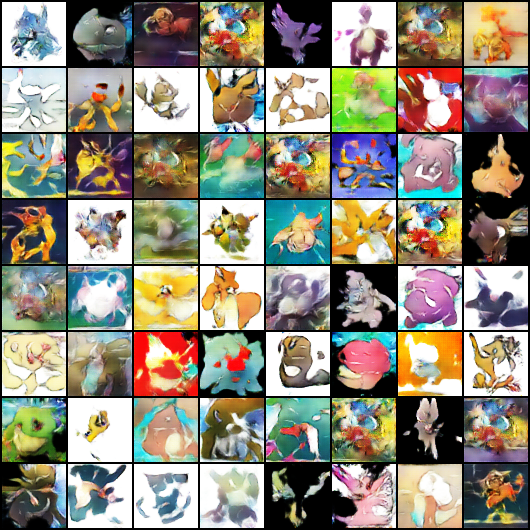

In [ ]:
#@title Checkpoint and Generated Image
from PIL import Image
glosses, dlosses, real, fake = history

checkpt_dir = 'checkpoint'
os.makedirs(checkpt_dir, exist_ok=True)
torch.save(generator.state_dict(), f'/content/{checkpt_dir}/Pokemon-generator.pt')
torch.save(discriminator.state_dict(), f'/content/{checkpt_dir}/Pokemon-discriminator.pt')
torch.save(generator, f'/content/{checkpt_dir}/pokemon')

Image.open('./generated/generated-pokemon-0'+ str(epochs) + '.png')

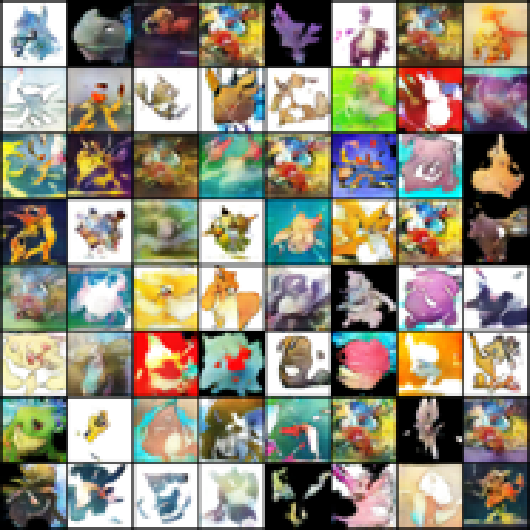

In [ ]:
#@title Generated Image as Pixel Art
import numpy as np

def pixelize(image_path, pixel_amt):
  im = Image.open(image_path)

  new_dim = [int(np.round(a*pixel_amt)) for a in im.size]

  return im.resize(new_dim).resize(im.size, resample = 4)

percent_pixelated=0.35 #@param {type:"slider", min:0.05, max:1, step:0.05}
pixelize('./generated/generated-pokemon-0'+ str(epochs) + '.png', percent_pixelated)

## Descriptive Graphs

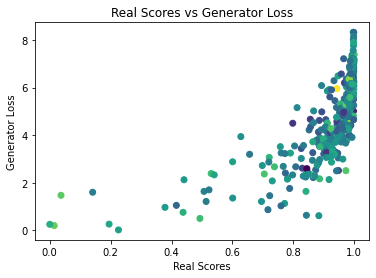

In [ ]:
#@title Real Scores vs Generator Loss
score_data = {'a': real, 'b': glosses, 'c': np.random.randn(epochs)}

plt.scatter('a', 'b', c='c', data=score_data)
plt.xlabel('Real Scores')
plt.ylabel('Generator Loss')
plt.title('Real Scores vs Generator Loss');

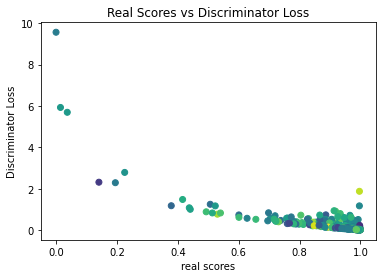

In [ ]:
#@title Real Scores vs Discriminator Loss
score_data = {'a': real, 'b': dlosses, 'c': np.random.randn(epochs)}

plt.scatter('a', 'b', c='c', data=score_data)
plt.xlabel('real scores')
plt.ylabel('Discriminator Loss')
plt.title('Real Scores vs Discriminator Loss');

[Text(0, 0.5, 'Discriminator Losses'),
 Text(0.5, 0, 'Generator Losses'),
 Text(0.5, 1.0, 'Losses: Generator vs Discriminator')]

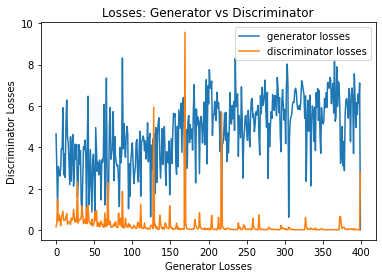

In [ ]:
#@title Generator Loss and Discriminator Loss over each Epoch
plt_losses = {'generator losses':glosses, 'discriminator losses': dlosses}

fig = sb.lineplot(data=plt_losses,  dashes = False)
fig.set(xlabel = 'Generator Losses',
        ylabel = 'Discriminator Losses',
        title='Losses: Generator vs Discriminator')

[Text(0, 0.5, 'score'),
 Text(0.5, 0, 'epoch'),
 Text(0.5, 1.0, 'Score: Real vs Fake')]

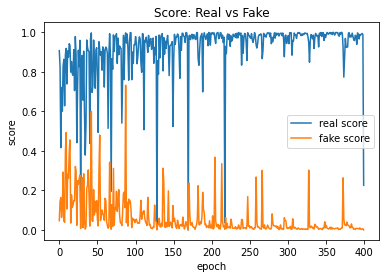

In [ ]:
#@title Real Scores and Fake Scores over each Epoch
plt_score = {'real score':real, 'fake score':fake}

fig1 = sb.lineplot(data=plt_score, dashes = False)
fig1.set(xlabel='epoch',
         ylabel='score',
         title='Score: Real vs Fake')


[Text(0, 0.5, 'Fake Scores'),
 Text(0.5, 0, 'Discriminator Losses'),
 Text(0.5, 1.0, 'Correlation of Discriminator Loss and Fake Score')]

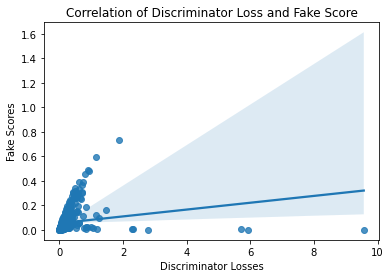

In [ ]:
#@title Regplot of Discriminator Loss and Fake Score
fig2 = sb.regplot(x=dlosses, y=fake)
fig2.set(xlabel='Discriminator Losses', 
         ylabel='Fake Scores', 
         title='Correlation of Discriminator Loss and Fake Score')

[Text(0, 0.5, 'fake scores'),
 Text(0.5, 0, 'generator losses'),
 Text(0.5, 1.0, 'Correlation of Generator Loss and Real Score')]

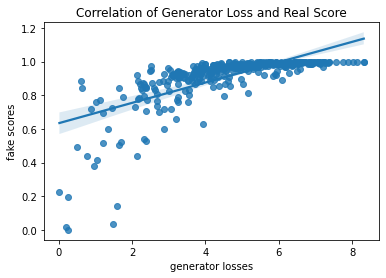

In [ ]:
#@title Regplot of Fake Scores vs Generator Loss
fig3 = sb.regplot(x=glosses, y=real)
fig3.set(xlabel='generator losses', ylabel='fake scores', title='Correlation of Generator Loss and Real Score')
